https://www.nature.com/articles/s41598-022-09765-x this cool as tool and also as a reference for DNA methylation works in the lab

## Load packages, functions and main data

In [1]:
# %load_ext rpy2.ipython

In [2]:
# %%R 
suppressMessages(suppressWarnings(library (GenomicFeatures)))
suppressMessages(suppressWarnings(library (tximport)))
suppressMessages(suppressWarnings(library (tidyverse)))
suppressMessages(suppressWarnings(library (ggplot2)))
suppressMessages(suppressWarnings(library (ggrepel)))
suppressMessages(suppressWarnings(library (DESeq2)))
suppressMessages(suppressWarnings(library (patchwork)))
suppressMessages(suppressWarnings(library (BiocParallel)))
suppressMessages(suppressWarnings(library (gridExtra)))
library(grid)

register(MulticoreParam(18))

In [3]:
library(pheatmap)
library(RColorBrewer)

In [4]:
source('../../scripts/util.R')

In [5]:
# Filter non-informative genes:
filter_low_counts <- function (dds_in , min_count=10){
    # all samples with a count of higher than `min_count`
    keep <- rowSums(counts(dds_in ) > min_count) == ncol(dds_in )
    dds_out <- dds_in [keep,]
    print (paste (nrow(dds_in), 'genes filtered to ->' , nrow(dds_out),'genes!', sep=' ') )
    return (dds_out)
}


plot_PCA <- function(vsd, colData, labels='', gr=c('cond'), title='', leg="none"){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(colour=group), alpha = 4/10,size=12) + 
            geom_point(shape = 1,size = 12,colour = "black") + 
            # geom_point(
            #     aes(color=group), 
            #     
            # size=10,
            # stroke = 0.5
            # ) +
            geom_text_repel(
                aes(label = labels),
                box.padding = 1.5, max.overlaps = Inf
            ) + #,size = 3.5)) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            ggtitle (title) + 
            scale_colour_Publication() + 
            theme_Publication(legend.position='top') +
            guides (size = 'none') + theme(legend.title = element_blank()) 
    return (pca)
}

In [6]:
write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}


correct_batch <- function (dds,gr,out,labels='',title=''){
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    p0 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' Before removeBatchEffect'))
    mat <- assay(vsd)
    
    mat <- limma::removeBatchEffect(mat, vsd$reps) # batch is same as time 
    assay(vsd) <- mat
    p1 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' After removeBatchEffect'))
    counts_batch_corrected <- assay(vsd)
    
    if (out == 'plot') {return (p0 + p1)}
    if (out == 'plot1'){return (p1)}
    if (out == 'vsd')  {return (vsd)}
    if (out == 'cbc')  {return (counts_batch_corrected)}
}


plot_gene_counts <- function (dds, gene_id,gene_name, intgroup){
    fiss <- plotCounts(dds, gene_id, intgroup = intgroup, returnData = TRUE)

    p <- ggplot(fiss,
      aes(x = cond, y = count, color = cond)) + 
      geom_point(size=5,alpha=8/10, position=position_jitter(h=0.15,w=0.15)) + 
      stat_summary(fun=mean, geom="line") +
      scale_y_log10() + 
      theme_bw() + 
      ggtitle(gene_name)
    
    return (p + theme_Publication())
}

Load annotations

In [7]:
herv_gff_file = '../../herv-genome/package-entities-erv.c.gff3'

herv_gff = rtracklayer::import(herv_gff_file)

# feature2ERV = herv_gff %>% 
#     data.frame %>% 
#     dplyr::filter(type == "BED_feature") %>% dplyr::select('ID','Name') %>% column_to_rownames('Name')

___
# Decitabine treatment RNA-Seq experiments

List every salmon quant files

In [8]:
# %%R
files <- list.files(path='herv/quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("herv/quants/(\\S+)/quant.sf","\\1",files)

In [9]:
for (f in files){print(f)}

[1] "herv/quants/hl60_combination_1/quant.sf"
[1] "herv/quants/hl60_combination_2/quant.sf"
[1] "herv/quants/hl60_decitabine_1/quant.sf"
[1] "herv/quants/hl60_decitabine_2/quant.sf"
[1] "herv/quants/hl60_dmso_1/quant.sf"
[1] "herv/quants/hl60_dmso_2/quant.sf"
[1] "herv/quants/hl60_rg3039_1/quant.sf"
[1] "herv/quants/hl60_rg3039_2/quant.sf"


In [10]:
txi <- tximport(files, type = "salmon", txOut=T)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 




In [11]:
# txi.erv <- summarizeToGene(txi, tx2gene = feature2ERV, ignoreAfterBar= TRUE)

#### Define sample sheet

In [12]:
colnames(txi$abundance) %>% length

[1] 8

In [13]:
colnames(txi$abundance)

[1] "hl60_combination_1" "hl60_combination_2" "hl60_decitabine_1" 
[4] "hl60_decitabine_2"  "hl60_dmso_1"        "hl60_dmso_2"       
[7] "hl60_rg3039_1"      "hl60_rg3039_2"

In [60]:
# meta 
conds  <- factor(c(
    rep('Combination',2),rep('Decitabine',2),rep('DMSO',2),rep('rg3039',2)
), levels = c('DMSO','Decitabine','rg3039','Combination'))

reps <- factor(c(
    rep(c('rep1','rep2'),4)
),c('rep1','rep2'))

colData <- data.frame(
    cond=conds,
    reps=reps,
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData

,cond,reps
,<fct>,<fct>
hl60_combination_1,Combination,rep1
hl60_combination_2,Combination,rep2
hl60_decitabine_1,Decitabine,rep1
hl60_decitabine_2,Decitabine,rep2
hl60_dmso_1,DMSO,rep1
hl60_dmso_2,DMSO,rep2
hl60_rg3039_1,rg3039,rep1
hl60_rg3039_2,rg3039,rep2


#### Save normalized counts

In [15]:
dds0 <- DESeqDataSetFromTximport(txi, colData, ~cond)
# dds <- DESeqDataSetFromTximport(txi.gene, colData, ~cond)

using counts and average transcript lengths from tximport



In [16]:
dds0 <- estimateSizeFactors(dds0)

using 'avgTxLength' from assays(dds), correcting for library size



In [17]:
ncu <- counts(dds0, normalized=TRUE) 

In [18]:
# write.table(
#     ncu[DAC_tx2gene$TXNAME,],'tinat/deseq2_norm.txt', sep="\t", quote=FALSE, col.names=TRUE
# )

### PCA
<!-- Initial principal component analysis (PCA) shows the second treated biological replicate at 72h time point, behaves as an outlier. Removing that from the analysis give us a better representation of our dataset. In the second PCA plot, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis. -->


In [19]:
dds.pca <- DESeq(dds0, parallel=TRUE)
# results 
vsd <- varianceStabilizingTransformation(dds.pca)

using pre-existing normalization factors

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



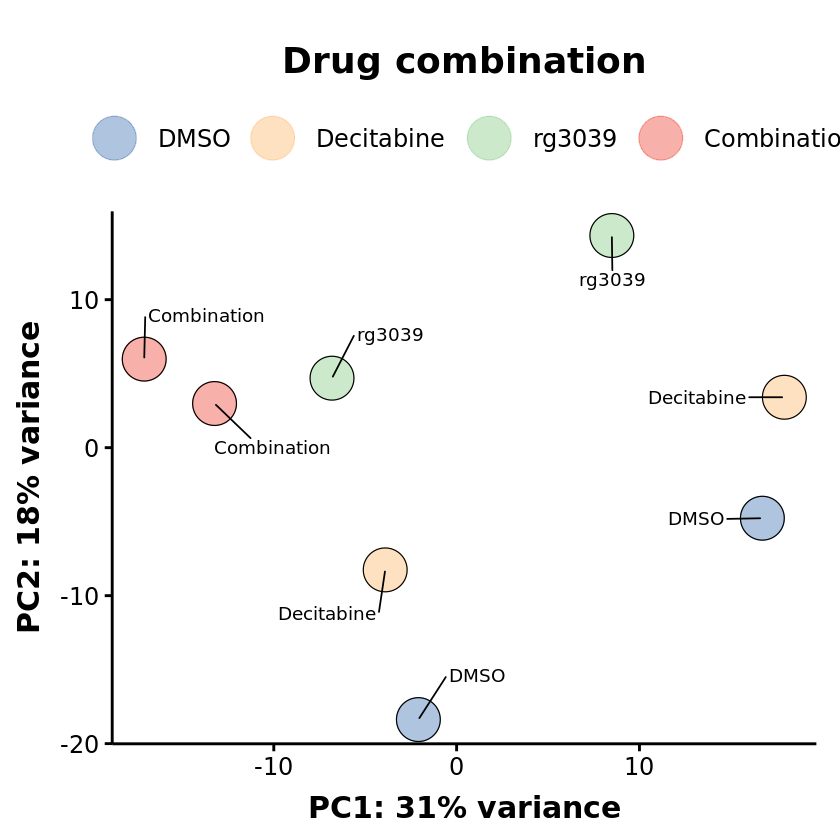

In [27]:
pca <- plot_PCA(
    vsd, 
    colData(vsd), 
    labels=colData(vsd)[,'cond'],
    gr=c('cond'), title='Drug combination')

pca

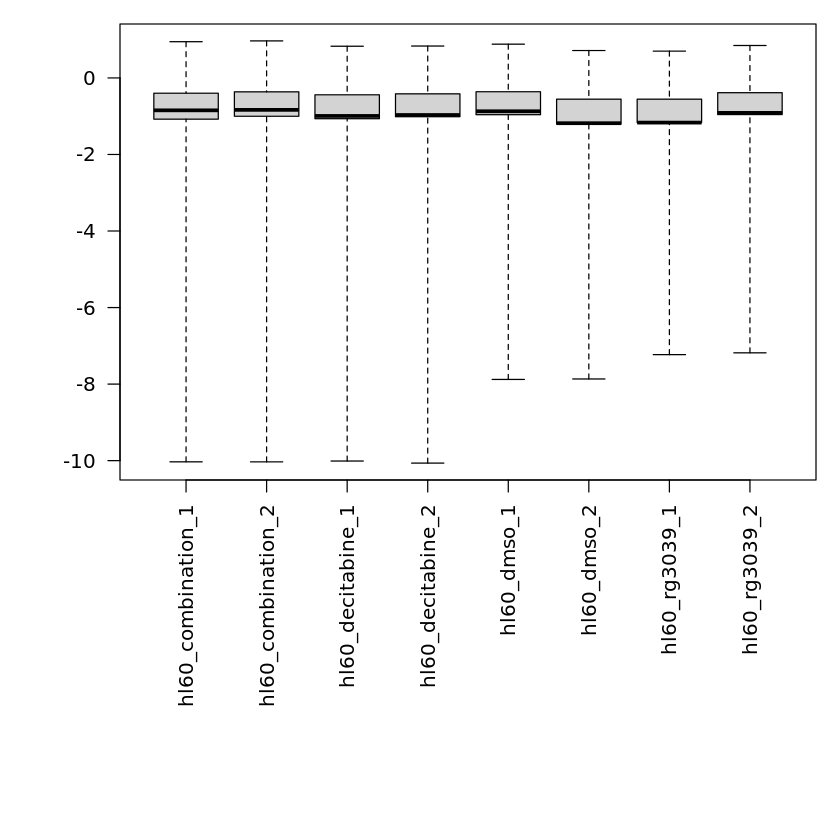

In [28]:
par(mar=c(15,5,1,1))
boxplot(log10(assays(dds.pca)[["cooks"]]), range=0, las=2)

In [39]:
levels(colData$cond)

[1] "DMSO"        "Decitabine"  "rg3039"      "Combination"

### 

In [61]:
colData2 = colData

In [62]:
# add dummy variables for drug treatment 
colData2$Decitabine <- factor(c(
    rep('Treated',4),rep('NotTreated',4)
),c('NotTreated','Treated'))

colData2$rg3039     <- factor(c(
    rep('Treated',2),rep('NotTreated',4),rep('Treated',2)
),c('NotTreated','Treated'))


colData2

,cond,reps,Decitabine,rg3039
,<fct>,<fct>,<fct>,<fct>
hl60_combination_1,Combination,rep1,Treated,Treated
hl60_combination_2,Combination,rep2,Treated,Treated
hl60_decitabine_1,Decitabine,rep1,Treated,NotTreated
hl60_decitabine_2,Decitabine,rep2,Treated,NotTreated
hl60_dmso_1,DMSO,rep1,NotTreated,NotTreated
hl60_dmso_2,DMSO,rep2,NotTreated,NotTreated
hl60_rg3039_1,rg3039,rep1,NotTreated,Treated
hl60_rg3039_2,rg3039,rep2,NotTreated,Treated


___

In [63]:
model.matrix(~0+Decitabine+rg3039+Decitabine*rg3039,colData2)

,DecitabineNotTreated,DecitabineTreated,rg3039Treated,DecitabineTreated:rg3039Treated
hl60_combination_1,0,1,1,1
hl60_combination_2,0,1,1,1
hl60_decitabine_1,0,1,0,0
hl60_decitabine_2,0,1,0,0
hl60_dmso_1,1,0,0,0
hl60_dmso_2,1,0,0,0
hl60_rg3039_1,1,0,1,0
hl60_rg3039_2,1,0,1,0


In [64]:
dds2 <- DESeqDataSetFromTximport(
    txi, colData2, ~0+Decitabine+rg3039+Decitabine*rg3039
)

# Annova test
dds2 <- DESeq(dds2, test="LRT", reduced=~1, parallel=TRUE)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [65]:
resultsNames(dds2)

[1] "DecitabineNotTreated"            "DecitabineTreated"              
[3] "rg3039Treated"                   "DecitabineTreated.rg3039Treated"

In [91]:
# contrast design: combination treatment vs dmso 
res_comb_vs_dmso  = results(dds2, contrast=list(
    c('DecitabineTreated','rg3039Treated','DecitabineTreated.rg3039Treated'),
    c('DecitabineNotTreated')
),listValues=c(1,-1)) %>% data.frame

In [92]:
# contrast design: decitabine treatment vs dmso 
res_decitabine_vs_dmso  = results(dds2, contrast=list(
    c('DecitabineTreated'),
    c('DecitabineNotTreated')
),listValues=c(1,-1)) %>% data.frame

___

In [74]:
model.matrix(~0+rg3039+Decitabine+Decitabine*rg3039,colData2)

,rg3039NotTreated,rg3039Treated,DecitabineTreated,rg3039Treated:DecitabineTreated
hl60_combination_1,0,1,1,1
hl60_combination_2,0,1,1,1
hl60_decitabine_1,1,0,1,0
hl60_decitabine_2,1,0,1,0
hl60_dmso_1,1,0,0,0
hl60_dmso_2,1,0,0,0
hl60_rg3039_1,0,1,0,0
hl60_rg3039_2,0,1,0,0


In [75]:
dds3 <- DESeqDataSetFromTximport(
    txi, colData2, ~0+rg3039+Decitabine+Decitabine*rg3039
)

# Annova test
dds3 <- DESeq(dds3, test="LRT", reduced=~1, parallel=TRUE)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [76]:
resultsNames(dds3)

[1] "rg3039NotTreated"                "rg3039Treated"                  
[3] "DecitabineTreated"               "rg3039Treated.DecitabineTreated"

In [93]:
# contrast design: combination treatment vs decitabine
res_comb_vs_decitabine  = results(dds3, contrast=list(
    c('rg3039Treated','rg3039Treated.DecitabineTreated'),
    c('rg3039NotTreated')
),listValues=c(1,-1)) %>% data.frame

In [94]:
# contrast design: rg3039 treatment vs dmso
res_rg3039_vs_dmso  = results(dds3, contrast=list(
    c('rg3039Treated'),
    c('rg3039NotTreated')
),listValues=c(1,-1)) %>% data.frame

In [95]:
# contrast design: combination treatment vs rg3039 
res_comb_vs_rg3039  = results(dds3, contrast=list(
    c('DecitabineTreated','rg3039Treated','rg3039Treated.DecitabineTreated'),
    c('rg3039NotTreated')
),listValues=c(1,-1)) %>% data.frame

___

In [96]:
RES = list(
    'comb_vs_dmso'=res_comb_vs_dmso, 
    'comb_vs_decitabine'=res_comb_vs_decitabine,
    'comb_vs_rg3039'=res_comb_vs_rg3039,
    'decitabine_vs_dmso'=res_decitabine_vs_dmso,
    'rg3039_vs_dmso'=res_rg3039_vs_dmso
    # 'rep2_vs_rep1'=res_rep2_vs_rep1
)

### merge results

In [97]:
RES %>% names

[1] "comb_vs_dmso"       "comb_vs_decitabine" "comb_vs_rg3039"    
[4] "decitabine_vs_dmso" "rg3039_vs_dmso"

In [99]:
result_table <- cbind(
    RES[['comb_vs_dmso']] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_dmso_log2FC=log2FoldChange,comb_vs_dmso_pvalue=pvalue),
    RES[['comb_vs_decitabine']] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_decitabine_log2FC=log2FoldChange,comb_vs_decitabine_pvalue=pvalue),
    RES[['comb_vs_rg3039']] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_rg3039_log2FC=log2FoldChange,comb_vs_rg3039_pvalue=pvalue),
    RES[['decitabine_vs_dmso']] %>% select('log2FoldChange','pvalue') %>% 
        rename(decitabine_vs_dmso_log2FC=log2FoldChange,decitabine_vs_dmso_pvalue=pvalue),
    RES[['rg3039_vs_dmso']] %>% select('log2FoldChange','pvalue') %>% 
        rename(rg3039_vs_dmso_log2FC=log2FoldChange,rg3039_vs_dmso_pvalue=pvalue)
    # RES[[6]] %>% select('log2FoldChange','pvalue') %>% 
    #     rename(rep2_vs_rep1_log2FC=log2FoldChange,rep2_vs_rep1_pvalue=pvalue)
) %>% drop_na

result_table <- result_table %>% replace(is.na(result_table),0)

In [100]:
result_table <- result_table %>% rownames_to_column('fullname') %>% 
        dplyr::rowwise() %>% dplyr::mutate(name = strsplit(fullname, split=":")[[1]][2]) %>% 
        data.frame %>%
        # filter(!duplicated(name_new)) %>%
    column_to_rownames('fullname') #%>% select(-name) 

In [101]:
write_Result(
    ncu,'herv/deseq2_norm.txt',col=T,row=T
)

In [102]:
write_Result(
    result_table,'herv/result_table.txt',col=T,row=T
)

In [103]:
# %>% group_by(name) %>% tally() %>% filter(n>50)
# # dplyr::filter(name %in% 'LTR67B')

## Plots

In [104]:
result_table = read.table(
    'herv/result_table.txt'
)

### scatter plot

In [105]:
prep_scatter <- function(p){
    p + 
    geom_point(
        data          = result_table %>% dplyr::filter(name %in% labels$name),
        colour='#3cedf0',size = 2, alpha = 1, show.legend = FALSE) + 
    geom_point(
        data          = result_table[labels %>% rownames,],
        shape = 21, colour = "#386cb0", fill = "#3cedf0", size = 2, stroke = 1,
        alpha = 1, show.legend = FALSE) + 
    geom_text_repel(
        data          = result_table[labels %>% rownames,],
        nudge_y       = 1.1 ,#- subset(dat, mpg > 30)$mpg,
        segment.size  = .2,
        size = 4,
        segment.color = "grey50",
        direction     = "x"
    ) +
    theme_bw(30) +
    theme(
        text=element_text(size=14),
        panel.background = element_rect(colour = "black"), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.ticks = element_line(size = .5)
        
    ) -> p
    return (p)
}

In [106]:
labels = result_table %>%
    dplyr::filter(
        (comb_vs_dmso_log2FC > 8 & comb_vs_dmso_log2FC  > 8) 
        &
        (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
        # &
        # (name %in% (result_table %>% 
        #      group_by(name) %>% tally() %>% filter(n<100) %>% 
        #      column_to_rownames('name') %>% rownames
        # ))
    ) %>% select(name)

# labels = result_table['ERV:HERVL+MLT2B3:<hg38:chr16:29002652-29008043:F>:1346575',]

In [119]:
result_table$label = ''

result_table[labels %>% rownames,]$label = 'PABL_A chr9:9641512-9642657'

In [122]:
result_table %>% ggplot + 
    aes(decitabine_vs_dmso_log2FC, comb_vs_dmso_log2FC, label = label) + 
    # "#fdb462", "#7fc97f
    geom_point(colour='gray90',size = 2, alpha = 1, show.legend = FALSE) + 
    xlab('log2FC\nDecitabine vs DMSO') + 
    ylab('log2FC\nCombination vs DMSO') + 
    theme_Publication() + 
    labs(colour = "") -> p1 


In [123]:
result_table %>% ggplot + 
    aes(rg3039_vs_dmso_log2FC, comb_vs_dmso_log2FC, label = label) + 
    # "#fdb462", "#7fc97f
    geom_point(colour='gray90',size = 2, alpha = 1, show.legend = FALSE) + 
    xlab('log2FC\nRG3039 vs DMSO') + 
    ylab('log2FC\nCombination vs DMSO') +     
    theme_Publication() + 
    labs(colour = "") -> p2
    # scale_y_continuous(breaks=NULL) 

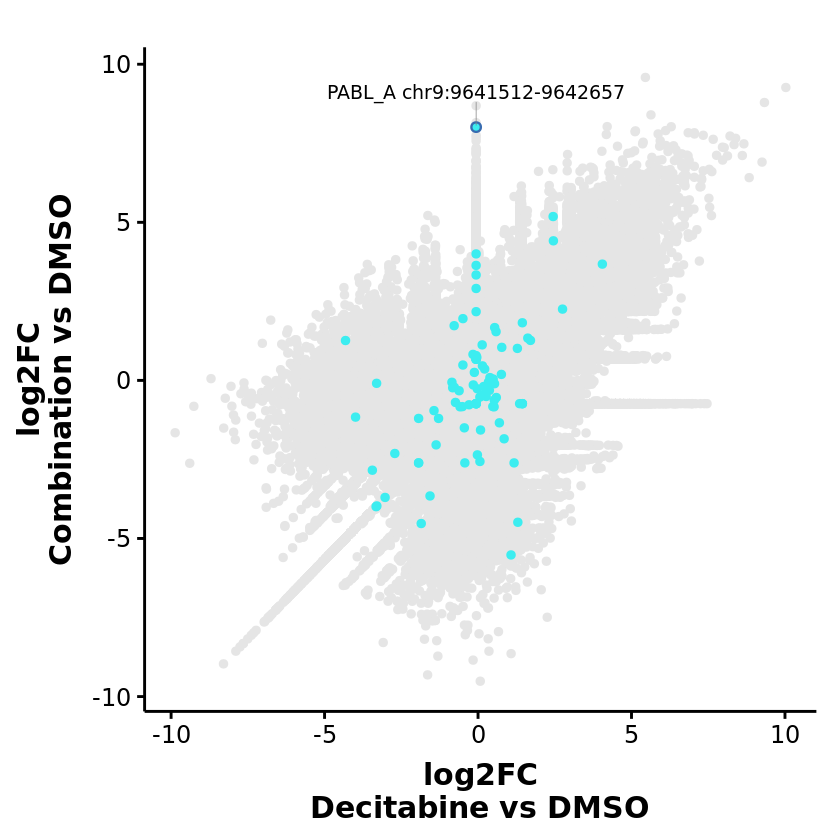

In [127]:
(prep_scatter(p1) + theme_Publication())
# & theme(plot.margin = unit(c(0.1,0.1,0.1,0.1), "cm"))

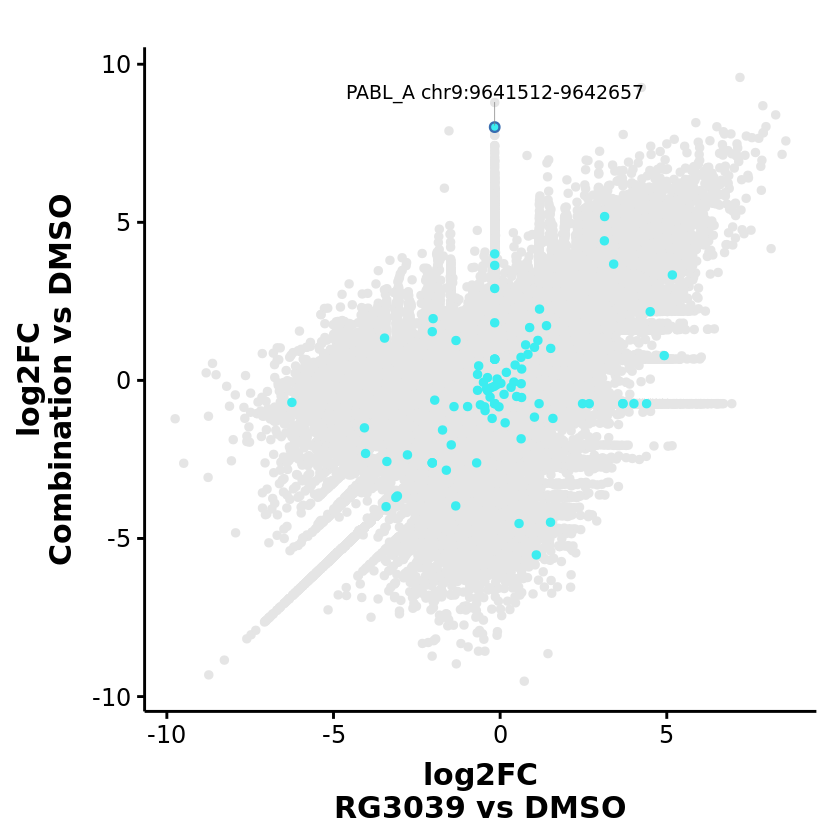

In [128]:
(prep_scatter(p2) + theme_Publication())

In [82]:
ggsave('herv/DAC-rg3039-ERV-expression-scatter.eps',
       plot=(
           prep_scatter(p1) + theme_Publication() + theme(axis.title = element_text(face = "plain", size = rel(0.8)))
       ) + (
           prep_scatter(p2) + theme_Publication() + theme(axis.title = element_text(face = "plain", size = rel(0.8)))
       ),       
       width = 10, height = 5, device='eps')

https://herv.img.cas.cz/entities/3669486

In [112]:
plot_gene_counts(
    dds2,
    'ERV:PABL_A:<hg38:chr9:9641512-9642657:F>:3669486',
    'PABL_A\nchr9:9641512-9642657',
    'cond'
) + 
xlab('') + 
theme(
    legend.position = "none",
    axis.title = element_text(face = "plain", size=16),
    axis.text.x = element_text(angle = 45,hjust=1),
    text=element_text(size=16),
    plot.title = element_text(face = "plain", size=16),
    
) -> p3

In [140]:
ggsave('herv/DAC-rg3039-ERV-expression-counts.pdf',
       plot=p3,
       width = 4, height = 5)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



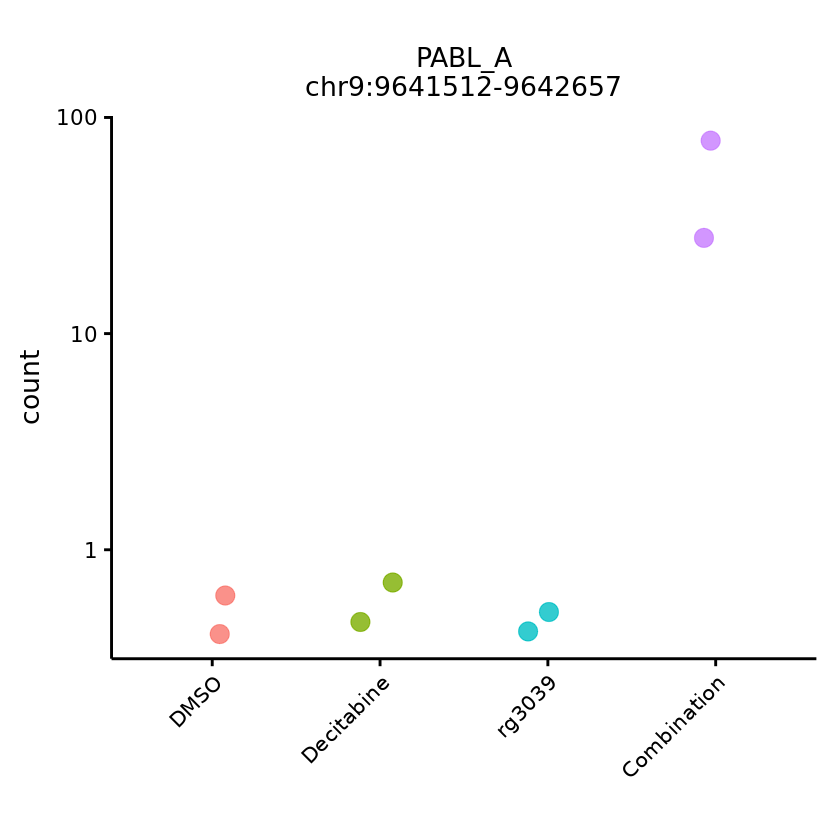

In [141]:
p3

### heatmap

In [ ]:
dim(ncu)[1] - sum(rowSums(ncu) == 0)

In [ ]:
heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
paired <- brewer.pal(n = 10, name = "Paired")


In [ ]:
ann_colors = list(
    cond = c('DMSO'= paired[1], 'Decitabine'=paired[3], 'rg3039'=paired[9],'Combination'=paired[10])
)

In [ ]:
ncu[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        dplyr::filter((abs(rep2_vs_rep1_log2FC) < 1 & rep2_vs_rep1_pvalue > 0.9) & (
            (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.05) |
            (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.05) |
            (abs(comb_vs_rg3039_log2FC) > 1 & comb_vs_rg3039_pvalue  < 0.05) |
            (abs(decitabine_vs_dmso_log2FC) > 1 & decitabine_vs_dmso_pvalue  < 0.05) |
            (abs(rg3039_vs_dmso_log2FC) > 1 & rg3039_vs_dmso_pvalue  < 0.05)
        )

        #     (
        #     (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.01) |
        #     (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.01)
        # ) & (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
            
        ) %>% 
    rownames
    , 
    # subset normalized counts
    colData %>% arrange(cond) %>% rownames
] %>% 
rownames_to_column('name') %>% 
        dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
        data.frame %>%
        filter(!duplicated(name_new)) %>%
    column_to_rownames('name_new') %>% select(-name) -> ncu1

ncu1 %>% dim

ncu1 %>%
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = T,
        cutree_rows = 5,
        main = 'Decitabine+rg3039 drug combination\nendogenous retrovirus (ERV)',
        annotation = colData %>% arrange(cond) %>% select(cond),
        cluster_cols = F, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('herv/heatmap_clustering.pdf', width=7, height=50)
grid::grid.newpage()
grid::grid.draw(hm$gtable)
dev.off()

In [ ]:
RES %>% names

In [ ]:
data.frame(assay(rld))[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        dplyr::filter(
            name %in% labels$name
            # (abs(comb_vs_decitabine_log2FC) > 5 & comb_vs_decitabine_log2FC  < 0.01) 
            # &
            # (abs(decitabine_vs_dmso_log2FC) < 1 & abs(rg3039_vs_dmso_log2FC) < 1)
            # &
            # (name %in% (result_table %>% 
            #      group_by(name) %>% tally() %>% filter(n<100) %>% 
            #      column_to_rownames('name') %>% rownames
            # ))

            (abs(rep2_vs_rep1_log2FC) < 1 & rep2_vs_rep1_pvalue > 0.9) & (
            (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.05) |
            (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.05) |
            (abs(comb_vs_rg3039_log2FC) > 1 & comb_vs_rg3039_pvalue  < 0.05) |
            (abs(decitabine_vs_dmso_log2FC) > 1 & decitabine_vs_dmso_pvalue  < 0.05) |
            (abs(rg3039_vs_dmso_log2FC) > 1 & rg3039_vs_dmso_pvalue  < 0.05)
        )

        #     (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.01) |
        #     (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.01)
        # ) & (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
        ) %>% 
    rownames
    , 
    # subset normalized counts
    colData %>% arrange(cond) %>% rownames
] -> rld1
# %>% 
# rownames_to_column('name') %>% 
#         dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
#         data.frame %>%
#         filter(!duplicated(name_new)) %>%
#     column_to_rownames('name_new') %>% 
# select(-name) 

rld1 %>%
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = T,
        cutree_rows = 2,
        main = 'Decitabine+rg3039 drug combination\nendogenous retrovirus (ERV)',
        annotation = colData %>% arrange(cond) %>% select(cond),
        cluster_cols = F, 
        # scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm

# # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# pdf('DAC-rg3039/RNA-seq/herv/heatmap_clustering_counts.pdf', width=7, height=50)
# grid::grid.newpage()
# grid::grid.draw(hm$gtable)
# dev.off()

### 

- ERVL-E 
    - https://herv.img.cas.cz/elements/72
    - https://dfam.org/family/DF0000120/summary

In [ ]:
ERVL.E='ERV:ERVL−E:<hg38:chr17:74540590−74541302:F>:1510718'

In [ ]:
ncu1 = ncu %>% rownames_to_column('name') %>% 
        dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
        data.frame %>%
        # filter(!duplicated(name_new)) %>%
        filter(name_new == 'ERVL−E')

In [ ]:
ncu1 %>% 
    # select(-name) %>% 
    head

# Session Info

In [130]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggthemes_4.2.4              scales_1.1.1               
 [3] RColorBrewer_1.1-2          pheatmap_1.0.12            
 [5] gridExtra_2.3               BiocParallel_1.28.0        
 [7] patchwork_1.1.1             DESeq2_1.34.0              
 [9] SummarizedExperim

In [391]:
date()

[1] "Fri Nov 11 13:22:12 2022"